# Packages 

In [1]:
#install pyathena if needed
#!pip install pyathena
from pyathena import connect

#!pip install -q smclarify==0.1
from smclarify.bias import report


In [2]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from pathlib import Path
from typing import Dict
from collections import defaultdict

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Set-up

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download Merged Data from Public S3 Bucket

In [4]:
# Public Flight Data
s3_client = boto3.client("s3")

BUCKET='ads-508-airline'
KEY='merged/Dec_modeling.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

pd.set_option('display.expand_frame_repr', False)
dec_merged = pd.read_csv(response.get("Body"))
dec_merged.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,AIRLINE_ID,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,0.0,245.0,1557.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,0.0,145.0,786.0,4,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,0.0,140.0,786.0,4,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,0.0,275.0,1709.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,0.0,270.0,1735.0,7,19393,Southwest Airlines Co.,8989,9668,15475,2482,0.02,0.0,0.0,58.0,9.84


In [5]:
dec_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558026 entries, 0 to 558025
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        558026 non-null  int64  
 1   DAY_OF_WEEK         558026 non-null  int64  
 2   OP_UNIQUE_CARRIER   558026 non-null  object 
 3   TAIL_NUM            558026 non-null  object 
 4   ORIGIN_AIRPORT_ID   558026 non-null  int64  
 5   ORIGIN              558026 non-null  object 
 6   DEST                558026 non-null  object 
 7   DEP_DEL15           558026 non-null  float64
 8   DEP_TIME_BLK        558026 non-null  object 
 9   ARR_TIME_BLK        558026 non-null  object 
 10  CANCELLED           558026 non-null  float64
 11  CRS_ELAPSED_TIME    558026 non-null  float64
 12  DISTANCE            558026 non-null  float64
 13  DISTANCE_GROUP      558026 non-null  int64  
 14  AIRLINE_ID          558026 non-null  int64  
 15  CARRIER_NAME        558026 non-nul

In [6]:
file_path = Path('../src/data/transformed_data/Dec_merged.csv')

if file_path.is_file():
    None
else:
    dec_merged.to_csv('../src/data/transformed_data/Dec_merged.csv', index=False)

# Set S3 Destination Location(Our S3 Private Bucket)

In [7]:
s3_private_path_csv = "s3://{}/ads508/data/merged".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-east-1-229768475194/ads508/data/merged


In [8]:
%store s3_private_path_csv

Stored 's3_private_path_csv' (str)


# Copy Downloaded Local Data to our Private S3 Bucket in this Account

In [9]:
!aws s3 cp $file_path $s3_private_path_csv/ 

upload: ../src/data/transformed_data/Dec_merged.csv to s3://sagemaker-us-east-1-229768475194/ads508/data/merged/Dec_merged.csv


In [10]:
!aws s3 ls $s3_private_path_csv/

2022-03-26 19:16:05  102283704 Dec_merged.csv


# Explore Class Labels 

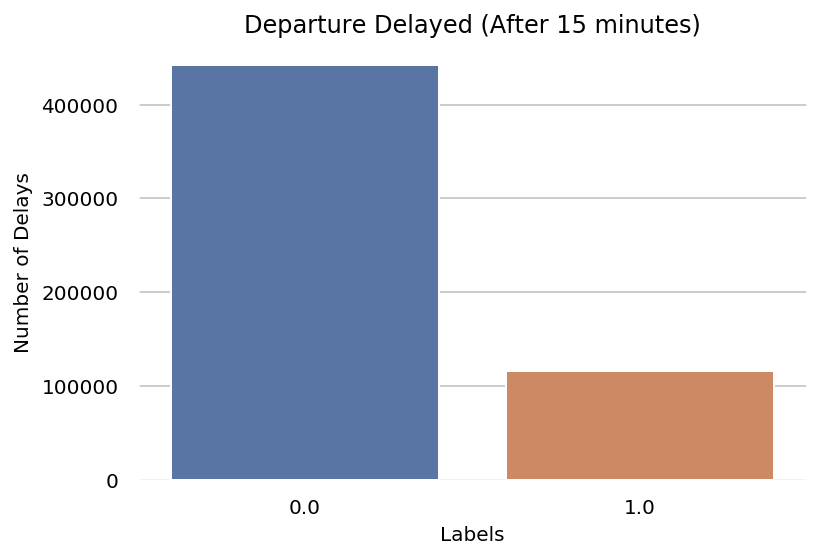

In [11]:
fig = sns.countplot(data=dec_merged, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

Summary:

- We are seeing a class imbalanced problem where there are more on-time departures than delays

# Balance the Data

In [12]:
df_grouped_by = dec_merged.groupby(["DEP_DEL15"])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()))
df_balanced = df_balanced.reset_index(drop=True)


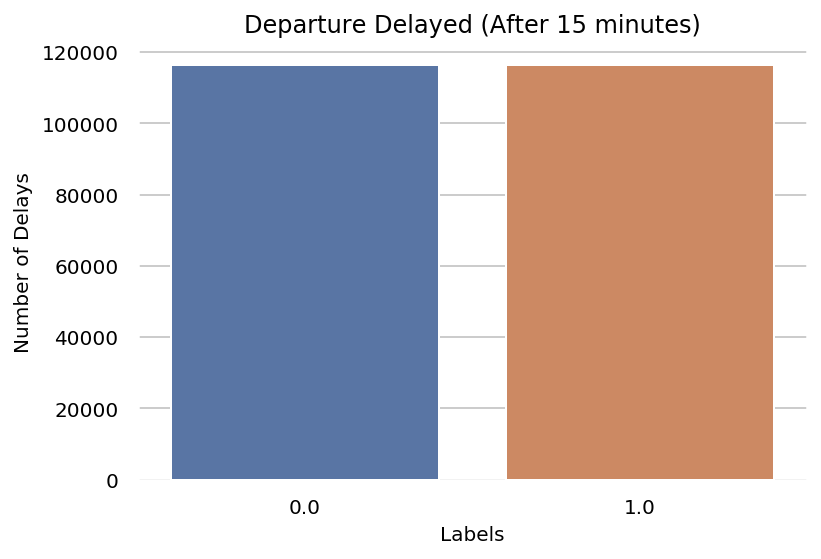

In [13]:
fig = sns.countplot(data=df_balanced, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

# Feature Engineering 

1. Feature Selection
2. Feature Creation 
3. Feature Transformation

## Feature Selection 

- We will disregard columns with IDs
- Also drop any redundant columns such as having only 1 distinct value 
- Since we have both the distance and distance group column, it is redundant 

In [14]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232584 entries, 0 to 232583
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DAY_OF_MONTH        232584 non-null  int64  
 1   DAY_OF_WEEK         232584 non-null  int64  
 2   OP_UNIQUE_CARRIER   232584 non-null  object 
 3   TAIL_NUM            232584 non-null  object 
 4   ORIGIN_AIRPORT_ID   232584 non-null  int64  
 5   ORIGIN              232584 non-null  object 
 6   DEST                232584 non-null  object 
 7   DEP_DEL15           232584 non-null  float64
 8   DEP_TIME_BLK        232584 non-null  object 
 9   ARR_TIME_BLK        232584 non-null  object 
 10  CANCELLED           232584 non-null  float64
 11  CRS_ELAPSED_TIME    232584 non-null  float64
 12  DISTANCE            232584 non-null  float64
 13  DISTANCE_GROUP      232584 non-null  int64  
 14  AIRLINE_ID          232584 non-null  int64  
 15  CARRIER_NAME        232584 non-nul

In [15]:
dropped = ['TAIL_NUM','ORIGIN_AIRPORT_ID','CANCELLED','AIRLINE_ID','DISTANCE']
df_balanced.drop(dropped, inplace=True, axis=1)

In [20]:
df_balanced.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,12,4,AA,CLT,ALB,0.0,2200-2259,0001-0559,113.0,3,American Airlines Inc.,8586,8586,15502,9677,0.00,0.0,0.0,49.0,8.95
1,13,5,YV,MSP,IAH,0.0,1500-1559,1800-1859,180.0,5,Mesa Airlines Inc.,1312,0,1205,34,0.00,0.0,0.0,74.0,4.03
2,13,5,WN,BWI,MDW,0.0,0600-0659,0700-0759,135.0,3,Southwest Airlines Co.,8989,9668,15475,2482,0.35,0.0,0.0,49.0,3.80
3,15,7,F9,DEN,MEM,0.0,0600-0659,0900-0959,142.0,4,Frontier Airlines Inc.,1473,2496,154,237,0.00,0.0,0.0,31.0,4.25
4,13,5,B6,FLL,RIC,0.0,1300-1359,1600-1659,132.0,4,JetBlue Airways,2840,4905,3888,726,0.08,0.0,0.0,80.0,9.17


# Quick upload for Data Wrangler Job

In [18]:
file_path = Path('../src/data/transformed_data/df_balanced.csv')

if file_path.is_file():
    None
else:
    df_balanced.to_csv('../src/data/transformed_data/df_balanced.csv', index=False)
    
s3_private_path_csv = "s3://{}/ads508/data/merged/balanced".format(bucket)

!aws s3 cp $file_path $s3_private_path_csv/ 
!aws s3 ls $s3_private_path_csv/

upload: ../src/data/transformed_data/df_balanced.csv to s3://sagemaker-us-east-1-229768475194/ads508/data/merged/balanced/df_balanced.csv
                           PRE /
2022-03-26 19:24:54   25926576 df_balanced.csv


# Store Variables for the Next Notebooks

In [ ]:
%store

# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}